# Music Transcription - Transformer Model (Local)

This notebook demonstrates the Audio Spectrogram Transformer (AST) model for automatic music transcription.
It has been adapted to run locally without requiring Kaggle or GitHub cloning.

**Prerequisites:**
- MAESTRO dataset should be available at `maestro-v3.0.0/`
- All dependencies installed from `requirements.txt`
- Run from project root directory

## Setup and Imports

In [9]:
# Environment setup
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

print(f"Current directory: {os.getcwd()}")
print(f"Expected: Should be in /root/music-transcription or project root")

Current directory: /root/music-transcription
Expected: Should be in /root/music-transcription or project root


In [10]:
# Core imports
import numpy as np
import torch
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pretty_midi
from torch.utils.data import DataLoader
from typing import List, Tuple

# Project imports - using local modules
from data.dataset import MaestroDataset
from models.cnn_rnn_model import CNNRNNModel, CNNRNNModelLarge
from models.transcription_model import TranscriptionModel
from models.remi_tokenizer import REMITokenizer

from train.train_transcriber import collate_ast

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

# Utility function for MIDI export
def piano_roll_to_midi(piano_roll, fs=31.25, program=0, output_path="output.mid"):
    """
    Convert piano roll to MIDI file.
    
    Args:
        piano_roll: Array (88, T) with note activations
        fs: Frames per second
        program: MIDI program number (0 = Acoustic Grand Piano)
        output_path: Where to save MIDI file
    """
    midi = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)
    
    # Track note onsets and offsets
    notes_on = {}
    
    for frame_idx in range(piano_roll.shape[1]):
        time = frame_idx / fs
        
        for note_num in range(88):
            midi_note = note_num + 21  # A0 = 21
            is_active = piano_roll[note_num, frame_idx] > 0
            
            if is_active and midi_note not in notes_on:
                # Note onset
                notes_on[midi_note] = time
            elif not is_active and midi_note in notes_on:
                # Note offset
                note = pretty_midi.Note(
                    velocity=100,
                    pitch=midi_note,
                    start=notes_on[midi_note],
                    end=time
                )
                instrument.notes.append(note)
                del notes_on[midi_note]
    
    # Close any remaining notes
    final_time = piano_roll.shape[1] / fs
    for midi_note, start_time in notes_on.items():
        note = pretty_midi.Note(
            velocity=100,
            pitch=midi_note,
            start=start_time,
            end=final_time
        )
        instrument.notes.append(note)
    
    midi.instruments.append(instrument)
    midi.write(output_path)
    print(f"MIDI file saved to {output_path}")

PyTorch version: 2.9.1+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 5090


## Dataset Exploration

In [11]:
# Initialize dataset
# Create dataset with waveforms
dataset = MaestroDataset(
    root_dir="maestro-v3.0.0",
    split="train",
    subset_size=100,
    return_waveform=True  # Returns raw audio instead of mel spectrograms
)

print(f"Dataset size: {len(dataset)}")
print(f"Sample rate: {dataset.sr}")
print(f"Mel bins: {dataset.n_mels}")
print(f"Hop length: {dataset.hop_length}")

Dataset size: 100
Sample rate: 16000
Mel bins: 229
Hop length: 512


In [12]:
# Load first sample
waveform, roll = dataset[0]

print(f"Waveform shape: {waveform.shape}")
print(f"Piano roll shape: {roll.shape}")
print(f"Duration: {roll.shape[1] * dataset.hop_length / dataset.sr:.2f} seconds")
print(f"Waveform duration: {len(waveform) / dataset.sr:.2f} seconds")

Waveform shape: torch.Size([11268399])
Piano roll shape: torch.Size([88, 21999])
Duration: 703.97 seconds
Waveform duration: 704.27 seconds


## REMI Tokenizer

Tokenizer for sequence-to-sequence transcription using REMI (Revamped MIDI) representation.
Now imported from `models.remi_tokenizer`.

In [13]:
# Test tokenizer
tokenizer = REMITokenizer()
print(f"Tokenizer vocab size: {tokenizer.vocab_size}")
print(f"SOS: {tokenizer.sos}, EOS: {tokenizer.eos}, PAD: {tokenizer.pad}")

# Test encode/decode
test_roll = roll  # Use the torch tensor directly
tokens = tokenizer.encode_from_pianoroll(test_roll, max_len=256)
print(f"Encoded to {len(tokens)} tokens (truncated to max_len=256)")
print(f"First 20 tokens: {tokens[:20]}")

# Decode back to verify
decoded_roll = tokenizer.decode_to_pianoroll(tokens, max_T=test_roll.shape[1])
print(f"Decoded piano roll shape: {decoded_roll.shape}")

Tokenizer vocab size: 512
SOS: 0, EOS: 1, PAD: 2
Encoded to 256 tokens (truncated to max_len=256)
First 20 tokens: [0, 329, 56, 210, 300, 323, 61, 210, 300, 310, 60, 210, 67, 210, 300, 50, 210, 300, 301, 161]
Decoded piano roll shape: torch.Size([88, 634])


## Audio Spectrogram Transformer (AST) Model

Transformer-based model using pretrained audio encoders for sequence-to-sequence transcription.

In [14]:
# Create AST model
# Note: You may see a warning about mel filters from transformers library.
# This is harmless - it's due to the pretrained AST model's feature extractor
# configuration and won't affect training or inference.
model = TranscriptionModel(
    model_type="ast",
    device="cuda",
    freeze_encoder=True
)

/usr/local/lib/python3.10/dist-packages/transformers/audio_utils.py:525: UserWarning: At least one mel filter has all zero values. The value for `num_mel_filters` (128) may be set too high. Or, the value for `num_frequency_bins` (257) may be set too low.
  warnings.warn(


## Training

Training loop for the transformer model.

In [8]:
# Training using the train_model function
from train.train_transcriber import train_model

# Train AST model on a subset for demonstration
model = train_model(
    root_dir="maestro-v3.0.0",
    split="train",
    year="2017",
    subset_size=100,  # Small subset for quick testing
    batch_size=2,  # Small batch for memory efficiency
    num_epochs=5,
    lr=1e-4,
    model_type="ast",  # Use AST transformer model
    freeze_encoder=True,  # Freeze pretrained encoder
    use_mock_encoder=False,  # Use real pretrained model (set True for testing without download)
    remi_vocab_size=512,
    decoder_layers=4,
    decoder_dim=384,
    decoder_heads=6,
    dropout=0.2,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

print("Training complete!")
print(f"Model saved and ready for inference")

Using device: cuda
Train set size: 100 files
Validation set size: 16 files


/usr/local/lib/python3.10/dist-packages/transformers/audio_utils.py:525: UserWarning: At least one mel filter has all zero values. The value for `num_mel_filters` (128) may be set too high. Or, the value for `num_frequency_bins` (257) may be set too low.
  warnings.warn(



Epoch 1/5


Train Loss: 3.0362 | Val Loss: 1.8389
Saved new best model to checkpoints/cnn_rnn.pth

Epoch 2/5


Train Loss: 1.1704 | Val Loss: 0.6655
Saved new best model to checkpoints/cnn_rnn.pth

Epoch 3/5


Train Loss: 0.4631 | Val Loss: 0.3004
Saved new best model to checkpoints/cnn_rnn.pth

Epoch 4/5


Train Loss: 0.2366 | Val Loss: 0.1871
Saved new best model to checkpoints/cnn_rnn.pth

Epoch 5/5


Train Loss: 0.1493 | Val Loss: 0.1273
Saved new best model to checkpoints/cnn_rnn.pth
Training complete!
Model saved and ready for inference


## Inference and Evaluation

Test the trained model on validation data.

/usr/local/lib/python3.10/dist-packages/transformers/audio_utils.py:525: UserWarning: At least one mel filter has all zero values. The value for `num_mel_filters` (128) may be set too high. Or, the value for `num_frequency_bins` (257) may be set too low.
  warnings.warn(


Loaded model from checkpoints/cnn_rnn.pth
Test dataset size: 10

Input waveform shape: torch.Size([2635930])
Ground truth roll shape: torch.Size([88, 5124])
Ground truth active frames: 35157
Predicted roll shape: torch.Size([1, 88, 5124])
Predicted roll (single) shape: torch.Size([88, 5124])
Predicted active frames: 0
Predicted min/max values: 0.000 / 0.000

=== Metrics ===
Frame-level Accuracy: 0.922
Precision: 0.000 (of predicted notes, % correct)
Recall: 0.000 (of ground truth notes, % found)
F1 Score: 0.000 (best overall metric)

Confusion Matrix:
  True Positives:  0
  False Positives: 0
  False Negatives: 35157
  True Negatives:  415755

Saved visualization to prediction_comparison.png


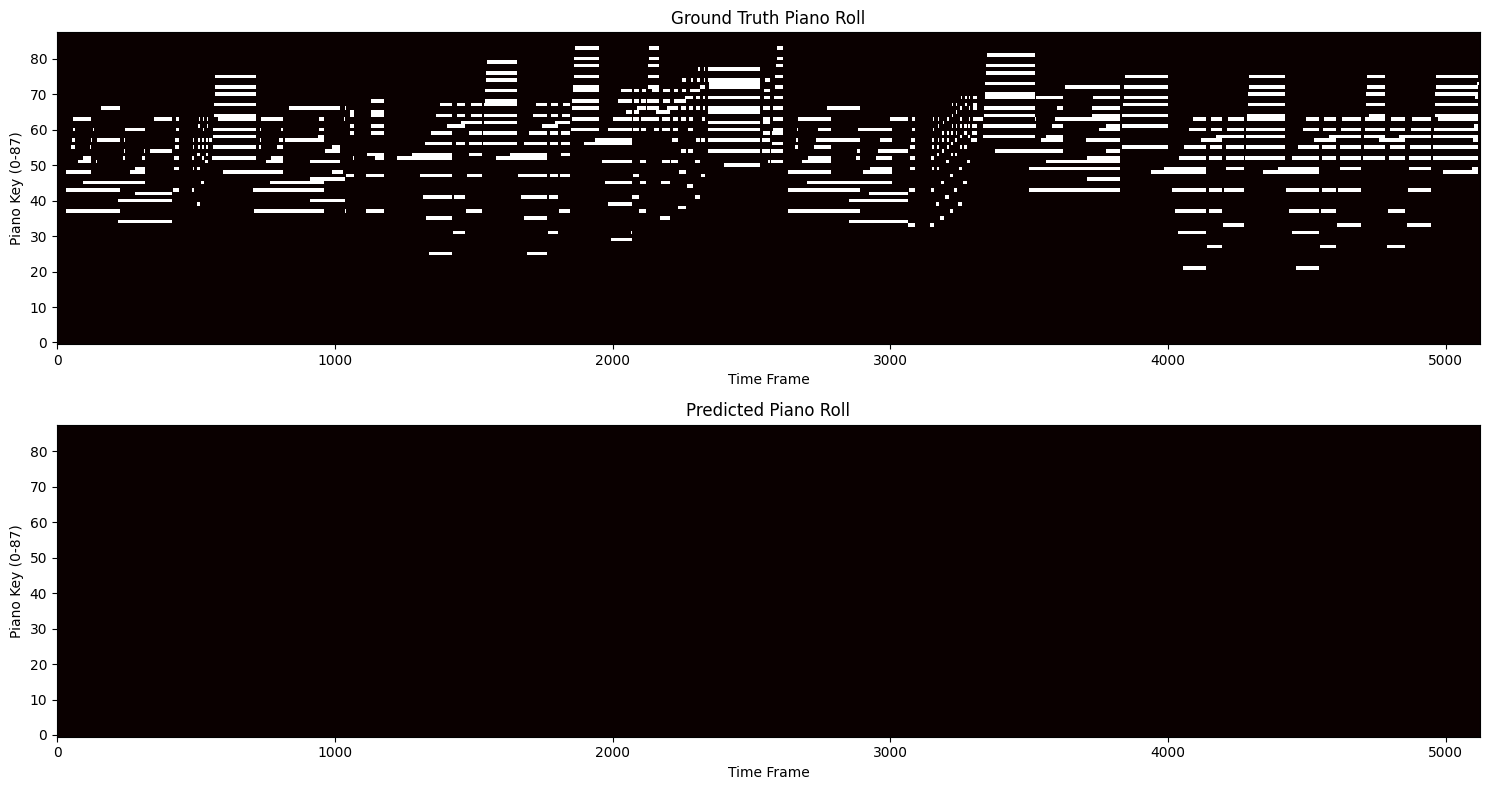


Skipping MIDI export (no notes predicted)


In [17]:
# Inference and Evaluation

# 1. Load the trained checkpoint
checkpoint_path = "checkpoints/cnn_rnn.pth"  # Path saved by train_model()

# Create model with same architecture
loaded_model = TranscriptionModel(
    model_type="ast",
    device="cuda" if torch.cuda.is_available() else "cpu",
    freeze_encoder=True,
    remi_vocab_size=512,
    decoder_layers=4,
    decoder_dim=384,
    decoder_heads=6,
    dropout=0.2
)

# Load the trained weights
loaded_model.load_state_dict(torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_available() else 'cpu'))
loaded_model.eval()

print(f"Loaded model from {checkpoint_path}")

# 2. Create test dataset
test_dataset = MaestroDataset(
    root_dir="maestro-v3.0.0",
    split="test",
    subset_size=10,  # Small subset for quick testing
    return_waveform=True
)

print(f"Test dataset size: {len(test_dataset)}")

# 3. Run inference on a single example
with torch.no_grad():
    # Get a test sample
    waveform, ground_truth_roll = test_dataset[0]
    
    print(f"\nInput waveform shape: {waveform.shape}")
    print(f"Ground truth roll shape: {ground_truth_roll.shape}")
    print(f"Ground truth active frames: {(ground_truth_roll > 0.5).sum().item()}")
    
    # Run prediction
    # For AST model, predict() expects waveform input and returns piano roll
    predicted_roll = loaded_model.predict(
        [waveform],  # Pass as list (batch of 1)
        sampling_rate=16000,
        generate_max_len=512,  # Generate more tokens
        max_T=ground_truth_roll.shape[1]  # Match ground truth length
    )
    
    print(f"Predicted roll shape: {predicted_roll.shape}")
    
    # The prediction is a batch, extract first item
    predicted_roll_single = predicted_roll[0]  # Shape: (88, T)
    
    print(f"Predicted roll (single) shape: {predicted_roll_single.shape}")
    print(f"Predicted active frames: {(predicted_roll_single > 0.5).sum().item()}")
    print(f"Predicted min/max values: {predicted_roll_single.min().item():.3f} / {predicted_roll_single.max().item():.3f}")
    
    # Binarize predictions (threshold at 0.5)
    pred_binary = (predicted_roll_single > 0.5).float()
    gt_binary = (ground_truth_roll > 0.5).float()
    
    # Calculate proper metrics (only on frames with notes)
    # True Positives: predicted note AND ground truth note
    tp = (pred_binary * gt_binary).sum()
    # False Positives: predicted note BUT NOT ground truth note
    fp = (pred_binary * (1 - gt_binary)).sum()
    # False Negatives: NOT predicted note BUT ground truth note
    fn = ((1 - pred_binary) * gt_binary).sum()
    # True Negatives: NOT predicted note AND NOT ground truth note
    tn = ((1 - pred_binary) * (1 - gt_binary)).sum()
    
    # Frame-level accuracy (can be misleading with sparse data)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    # Precision: of all predicted notes, how many were correct?
    precision = tp / (tp + fp + 1e-8)
    
    # Recall: of all ground truth notes, how many did we find?
    recall = tp / (tp + fn + 1e-8)
    
    # F1 Score: harmonic mean of precision and recall
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    
    print(f"\n=== Metrics ===")
    print(f"Frame-level Accuracy: {accuracy.item():.3f}")
    print(f"Precision: {precision.item():.3f} (of predicted notes, % correct)")
    print(f"Recall: {recall.item():.3f} (of ground truth notes, % found)")
    print(f"F1 Score: {f1.item():.3f} (best overall metric)")
    print(f"\nConfusion Matrix:")
    print(f"  True Positives:  {tp.item():.0f}")
    print(f"  False Positives: {fp.item():.0f}")
    print(f"  False Negatives: {fn.item():.0f}")
    print(f"  True Negatives:  {tn.item():.0f}")
    
# 4. Visualize predictions
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Ground truth
axes[0].imshow(ground_truth_roll.numpy(), aspect='auto', origin='lower', cmap='hot', interpolation='nearest')
axes[0].set_title('Ground Truth Piano Roll')
axes[0].set_ylabel('Piano Key (0-87)')
axes[0].set_xlabel('Time Frame')

# Prediction
axes[1].imshow(predicted_roll_single.cpu().numpy(), aspect='auto', origin='lower', cmap='hot', interpolation='nearest')
axes[1].set_title('Predicted Piano Roll')
axes[1].set_ylabel('Piano Key (0-87)')
axes[1].set_xlabel('Time Frame')

plt.tight_layout()
plt.savefig('prediction_comparison.png')
print("\nSaved visualization to prediction_comparison.png")
plt.show()

# 5. Export prediction to MIDI (only if there are notes)
if pred_binary.sum() > 0:
    fs = test_dataset.sr / test_dataset.hop_length
    piano_roll_to_midi(
        predicted_roll_single.cpu().numpy(),
        fs=fs,
        output_path="predicted_transcription.mid"
    )
    
    piano_roll_to_midi(
        ground_truth_roll.numpy(),
        fs=fs,
        output_path="ground_truth_transcription.mid"
    )
    
    print("\nInference complete!")
    print("Compare the MIDI files:")
    print("  - predicted_transcription.mid (model output)")
    print("  - ground_truth_transcription.mid (reference)")
else:
    print("\nSkipping MIDI export (no notes predicted)")

## MIDI Export Demo

The `piano_roll_to_midi()` utility function is defined in the imports cell and can be used throughout the notebook.

In [8]:
# MIDI Export Demo
# The piano_roll_to_midi function is defined in the imports cell above

# Test MIDI export with the ground truth from the dataset
test_output = "test_output.mid"
fs = dataset.sr / dataset.hop_length
piano_roll_to_midi(roll.numpy(), fs=fs, output_path=test_output)
print(f"Created test MIDI file: {test_output}")

MIDI file saved to test_output.mid
Created test MIDI file: test_output.mid
